In [ ]:
# CELL 1: Imports & Setup
# !pip install pandas numpy scikit-learn matplotlib seaborn transformers torch datasets tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from transformers import pipeline
import re

# Set plotting style
sns.set(style='whitegrid')
print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# CELL 2: Data Loading (TweetEval)
print("Loading TweetEval dataset (sentiment task)...")
dataset = load_dataset("tweet_eval", "sentiment")

# Helper function to convert the dataset object into clean lists
def process_split(split_name):
    """Extracts texts and converts integer labels to strings."""
    data = dataset[split_name]
    texts = [str(t).strip() for t in data['text']]

    # TweetEval labels: 0=negative, 1=neutral, 2=positive
    labels = data['label']

    return texts, labels

# Load all 3 splits directly from the benchmark
print("Processing splits...")
X_train, y_train = process_split('train')
X_val, y_val = process_split('validation')
X_test, y_test = process_split('test')

print(f"Training Set:   {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set:       {len(X_test)} samples")
print(f"Sample Data: {X_train[0]} -> {y_train[0]}")

Loading TweetEval dataset (sentiment task)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Processing splits...
Training Set:   45615 samples
Validation Set: 2000 samples
Test Set:       12284 samples
Sample Data: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin" -> 2


In [ ]:
# CELL 3: Naive Bayes (Optimized Preprocessing)
def clean_text_for_ml(text):
    """
    Cleans text specifically for simple ML models (NB/LR).
    RoBERTa does NOT use this (it likes raw text).
    """
    text = str(text).lower()
    # TweetEval uses '@user' as a placeholder. It confuses TF-IDF. Remove it.
    text = text.replace("@user", "")
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Keep only letters and spaces (remove hashtags/punctuation)
    text = re.sub(r"[^a-z\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

print("Training Multinomial Naive Bayes (with cleaning)...")

# We create a new list of cleaned text just for these models
X_train_clean = [clean_text_for_ml(t) for t in X_train]
X_val_clean = [clean_text_for_ml(t) for t in X_val]
X_test_clean = [clean_text_for_ml(t) for t in X_test]

model_nb = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

model_nb.fit(X_train_clean, y_train)
pred_nb = model_nb.predict(X_val_clean)
acc_nb = accuracy_score(y_val, pred_nb)

print(f"Naive Bayes Validation Accuracy: {acc_nb:.2%}")

Training Multinomial Naive Bayes (with cleaning)...
Naive Bayes Validation Accuracy: 63.15%


In [ ]:
# CELL 4: Logistic Regression (Optimized Preprocessing)
print("Training Logistic Regression (with cleaning)...")

model_lr = Pipeline([
    # Reduced max_features to 5000 to prevent overfitting on noise
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', LogisticRegression(C=1, max_iter=1000, class_weight='balanced'))
])

model_lr.fit(X_train_clean, y_train)
pred_lr = model_lr.predict(X_val_clean)
acc_lr = accuracy_score(y_val, pred_lr)

print(f"Logistic Regression Validation Accuracy: {acc_lr:.2%}")

Training Logistic Regression (with cleaning)...
Logistic Regression Validation Accuracy: 63.45%


In [ ]:
# CELL 5: Evaluate Using RoBERTa (CardiffNLP)
# -------------------------------------------------
print("Checking for GPU...")
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU (Fast)' if device == 0 else 'CPU (Slow)'}")

print("Loading 'cardiffnlp/twitter-roberta-base-sentiment'...")
hf_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    max_length=512,
    truncation=True,
    device=device
)

# Map HF model outputs to integer labels
# Model output: LABEL_0 (Neg), LABEL_1 (Neu), LABEL_2 (Pos)
label_map_hf = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}

print("Running inference on TweetEval validation split...")
pred_hf = []

batch_size = 32
for start in tqdm(range(0, len(X_val), batch_size), desc="RoBERTa Inference"):
    end = start + batch_size
    batch = X_val[start:end]
    results = hf_pipe(batch)
    for res in results:
        pred_hf.append(label_map_hf[res["label"]])

acc_hf = accuracy_score(y_val, pred_hf)
print(f"RoBERTa Validation Accuracy: {acc_hf:.2%}")

Checking for GPU...
Using device: GPU (Fast)
Loading 'cardiffnlp/twitter-roberta-base-sentiment'...


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Running inference on TweetEval validation split...


RoBERTa Inference:   0%|          | 0/63 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


RoBERTa Validation Accuracy: 80.75%


In [ ]:
# CELL 6: Evaluate MarieAngeA13/Sentiment-Analysis-BERT
# -------------------------------------------------------------
# This is a BERT base model fine-tuned for sentiment.
# It usually supports 3 classes: Positive, Negative, Neutral.

MODEL_NAME_1 = "MarieAngeA13/Sentiment-Analysis-BERT"
print(f"--- EVALUATING MODEL: {MODEL_NAME_1} ---")

pipe_1 = pipeline("sentiment-analysis", model=MODEL_NAME_1, device=device, truncation=True, max_length=512)

print(f"Running inference on {len(X_val)} samples...")
preds_1 = []

for text in tqdm(X_val, desc="BERT Processing"):
    try:
        result = pipe_1(text)[0]
        label = result['label'].lower()

        # Map output labels to integers (0=Neg, 1=Neu, 2=Pos)
        if 'positive' in label:
            preds_1.append(2)
        elif 'negative' in label:
            preds_1.append(0)
        else:
            preds_1.append(1) # Neutral

    except Exception as e:
        # Fallback in case of truncation error on very long text
        preds_1.append(1)

acc_bert = accuracy_score(y_val, preds_1)
print(f"\nResults for {MODEL_NAME_1}:")
print(f"Accuracy: {acc_bert:.2%}")
print(classification_report(y_val, preds_1, target_names=['Negative', 'Neutral', 'Positive']))

--- EVALUATING MODEL: MarieAngeA13/Sentiment-Analysis-BERT ---


config.json:   0%|          | 0.00/944 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Running inference on 2000 samples...


BERT Processing:   0%|          | 0/2000 [00:00<?, ?it/s]


Results for MarieAngeA13/Sentiment-Analysis-BERT:
Accuracy: 64.55%
              precision    recall  f1-score   support

    Negative       0.52      0.55      0.54       312
     Neutral       0.59      0.78      0.67       869
    Positive       0.84      0.53      0.65       819

    accuracy                           0.65      2000
   macro avg       0.65      0.62      0.62      2000
weighted avg       0.68      0.65      0.64      2000



In [ ]:
# CELL 7: Evaluate siebert/sentiment-roberta-large-english
# ----------------------------------------------------------------
# A large RoBERTa model. NOTE: This is a BINARY model (Positive/Negative only).
# We must filter out Neutrals from validation to test this fairly.

MODEL_NAME_2 = "siebert/sentiment-roberta-large-english"
print(f"--- EVALUATING MODEL: {MODEL_NAME_2} ---")

pipe_2 = pipeline("sentiment-analysis", model=MODEL_NAME_2, device=device, truncation=True, max_length=512)

preds_2 = []
valid_indices = [] # Track which samples are valid for binary comparison

print("Running inference (Skipping Neutral samples)...")
for i, text in enumerate(tqdm(X_val, desc="Siebert Processing")):
    # Skip Neutral ground truth labels (Label 1) for fair binary evaluation
    if y_val[i] == 1:
        continue

    valid_indices.append(i)

    result = pipe_2(text)[0]
    label = result['label'].upper()

    # Map Siebert labels to TweetEval integers (0=Neg, 2=Pos)
    if label == 'POSITIVE':
        preds_2.append(2)
    else:
        preds_2.append(0)

# Create a filtered list of ground truth labels corresponding to the predictions
binary_y_val = [y_val[i] for i in valid_indices]

acc_siebert = accuracy_score(binary_y_val, preds_2)
print(f"\nResults for {MODEL_NAME_2} (Binary Only):")
print(f"Accuracy: {acc_siebert:.2%}")
print(classification_report(binary_y_val, preds_2, target_names=['Negative', 'Positive']))
print("(Note: Neutral samples were excluded for this binary model evaluation.)")

--- EVALUATING MODEL: siebert/sentiment-roberta-large-english ---


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Running inference (Skipping Neutral samples)...


Siebert Processing:   0%|          | 0/2000 [00:00<?, ?it/s]


Results for siebert/sentiment-roberta-large-english (Binary Only):
Accuracy: 90.63%
              precision    recall  f1-score   support

    Negative       0.81      0.86      0.83       312
    Positive       0.95      0.92      0.93       819

    accuracy                           0.91      1131
   macro avg       0.88      0.89      0.88      1131
weighted avg       0.91      0.91      0.91      1131

(Note: Neutral samples were excluded for this binary model evaluation.)


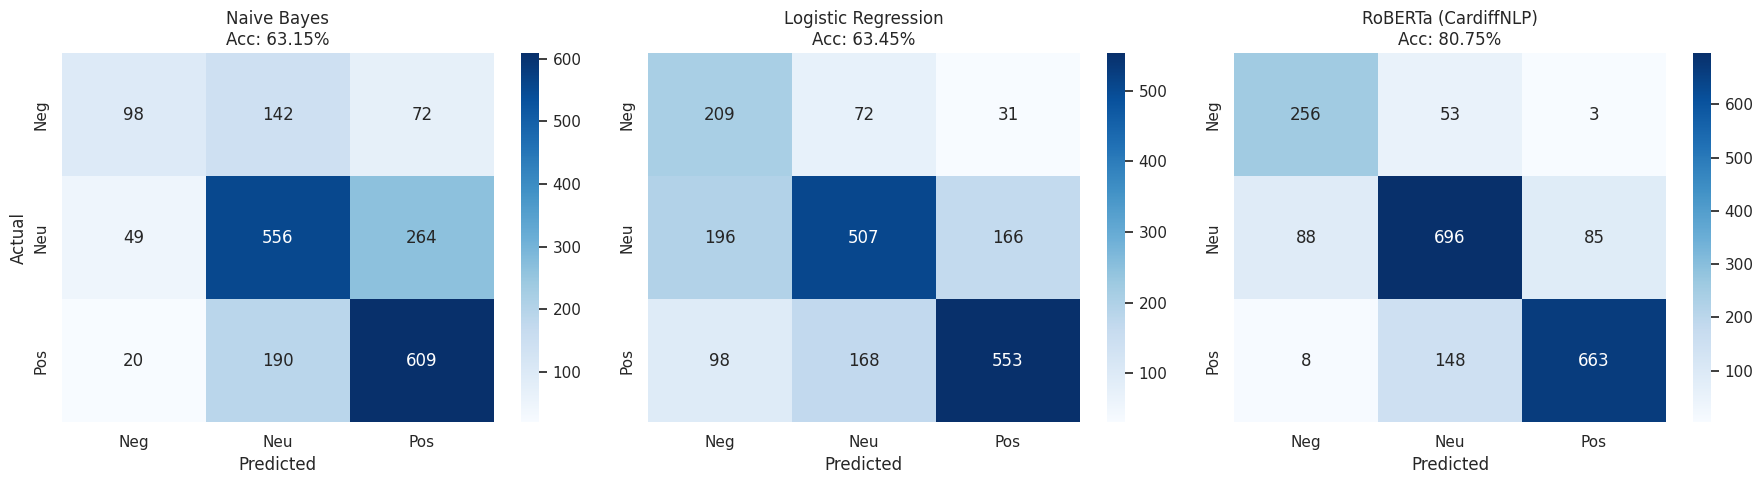

In [ ]:
# CELL 8: Confusion Matrices (Original 3 Models)
# We plot the main 3 models to keep the visual comparison clean.
models = ['Naive Bayes', 'Logistic Regression', 'RoBERTa (CardiffNLP)']
preds = [pred_nb, pred_lr, pred_hf]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, p) in enumerate(zip(models, preds)):
    cm = confusion_matrix(y_val, p, labels=[0, 1, 2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])

    current_acc = accuracy_score(y_val, p)
    axes[i].set_title(f"{name}\nAcc: {current_acc:.2%}")
    axes[i].set_xlabel('Predicted')
    if i == 0: axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Generating t-SNE plot for TweetEval Validation Set...


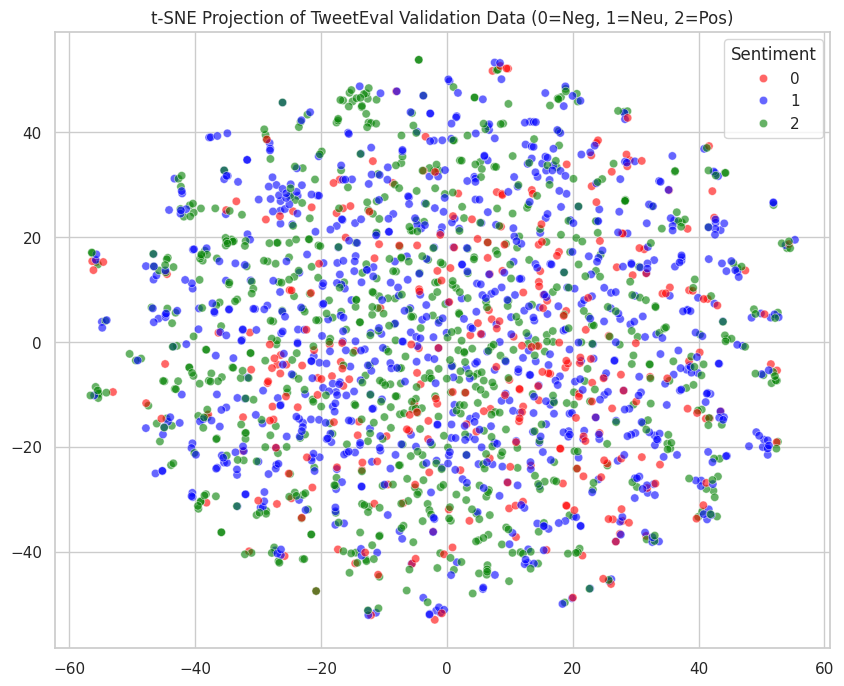

In [ ]:
# CELL 9: t-SNE Visualization
print("Generating t-SNE plot for TweetEval Validation Set...")
tfidf_viz = TfidfVectorizer(max_features=1000)
X_val_tfidf = tfidf_viz.fit_transform(X_val)

# Perplexity=30 is standard for this dataset size
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_val_tfidf.toarray())

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y_val,
    palette={2: 'green', 0: 'red', 1: 'blue'},
    alpha=0.6
)
plt.title("t-SNE Projection of TweetEval Validation Data (0=Neg, 1=Neu, 2=Pos)")
plt.legend(title="Sentiment")
plt.show()

In [ ]:
# CELL 10: Final Evaluation on Test Set
# We select the best model (likely RoBERTa) and run it on the Test Set once.

print("--- SELECTING BEST MODEL ---\n")
# Comparing the 3-class models on the full validation set
scores = {
    "Naive Bayes": acc_nb,
    "Logistic Regression": acc_lr,
    "RoBERTa (CardiffNLP)": acc_hf,
    "BERT (MarieAnge)": acc_bert
}

best_name = max(scores, key=scores.get)
print(f"Best performing model on Validation Set: {best_name} ({scores[best_name]:.2%})")

print(f"\n--- FINAL EVALUATION ON TEST SET ({best_name}) ---")

# We default to CardiffNLP RoBERTa if it wins (which is expected) or handle others
if "RoBERTa" in best_name:
    final_preds = []
    for start in tqdm(range(0, len(X_test), batch_size), desc="Final Testing"):
        end = start + batch_size
        batch = X_test[start:end]
        results = hf_pipe(batch)
        final_preds.extend([label_map_hf[res["label"]] for res in results])

    print("Test Set Accuracy:", accuracy_score(y_test, final_preds))
    print(classification_report(y_test, final_preds, target_names=['Negative', 'Neutral', 'Positive']))

elif "BERT" in best_name:
    final_preds = []
    for text in tqdm(X_test, desc="Final Testing"):
        try:
            result = pipe_1(text)[0]
            label = result['label'].lower()
            if 'positive' in label: final_preds.append(2)
            elif 'negative' in label: final_preds.append(0)
            else: final_preds.append(1)
        except: final_preds.append(1)

    print("Test Set Accuracy:", accuracy_score(y_test, final_preds))
    print(classification_report(y_test, final_preds, target_names=['Negative', 'Neutral', 'Positive']))

--- SELECTING BEST MODEL ---

Best performing model on Validation Set: RoBERTa (CardiffNLP) (80.75%)

--- FINAL EVALUATION ON TEST SET (RoBERTa (CardiffNLP)) ---


Final Testing:   0%|          | 0/384 [00:00<?, ?it/s]

Test Set Accuracy: 0.7244382937154021
              precision    recall  f1-score   support

    Negative       0.71      0.78      0.74      3972
     Neutral       0.74      0.69      0.71      5937
    Positive       0.72      0.71      0.71      2375

    accuracy                           0.72     12284
   macro avg       0.72      0.73      0.72     12284
weighted avg       0.73      0.72      0.72     12284

